In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import xgboost as xgb
import joblib
import optuna
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    precision_recall_curve,
    auc,
    f1_score,
)
import warnings

In [2]:
# Suppress unimportant warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
# Wrapper for sklearn compatibility
class XGBClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, **params):
        self.eval_set = params.pop("eval_set", None)
        self.early_stopping_rounds = params.pop("early_stopping_rounds", None)
        
        params.setdefault("tree_method", "gpu_hist")
        params.setdefault("device", "cuda")
        
        self.model = xgb.XGBClassifier(eval_metric="auc", **params)
        self.is_booster = False

    def fit(self, X, y, eval_set=None, early_stopping_rounds=None, verbose=True):
        eval_set = eval_set or self.eval_set
        early_stopping_rounds = early_stopping_rounds or self.early_stopping_rounds
        if early_stopping_rounds and eval_set:
            dtrain = xgb.DMatrix(X, label=y)
            deval = xgb.DMatrix(eval_set[0][0], label=eval_set[0][1])
            evals = [(dtrain, "train"), (deval, "validation")]
            self.model = xgb.train(
                self.model.get_params(),
                dtrain,
                num_boost_round=1000,
                evals=evals,
                early_stopping_rounds=early_stopping_rounds,
                verbose_eval=verbose,
            )
            self.is_booster = True
        else:
            self.model.fit(X, y, eval_set=eval_set, verbose=verbose)
            self.is_booster = False
        return self

    def predict(self, X):
        dmatrix = xgb.DMatrix(X) if self.is_booster else X
        raw_preds = self.model.predict(dmatrix)
        return (raw_preds > 0.5).astype(int)

    def predict_proba(self, X):
        dmatrix = xgb.DMatrix(X) if self.is_booster else X
        raw_preds = self.model.predict(dmatrix)
        return np.column_stack([1 - raw_preds, raw_preds])

    def get_params(self, deep=True):
        params = self.model.get_params(deep)
        params.update({"eval_set": self.eval_set, "early_stopping_rounds": self.early_stopping_rounds})
        return params

In [4]:
# Utility to load splits
def load_splits(save_dir):
    data_splits = {}
    for file_name in os.listdir(save_dir):
        if file_name.endswith(".pkl"):
            key = file_name.split(".pkl")[0]
            with open(os.path.join(save_dir, file_name), "rb") as f:
                data = pickle.load(f)
                data_splits[key] = np.array(data) if isinstance(data, (pd.DataFrame, pd.Series)) else data
    return data_splits

In [5]:
# Cross-validation function
def cross_validate_with_regularization(X, y, params):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = XGBClassifierWrapper(**params)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=10,  # Only included when eval_set is provided
            verbose=False,
        )
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        cv_scores.append(roc_auc_score(y_val, y_pred_proba))

    return np.mean(cv_scores), np.std(cv_scores)

In [6]:
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.01, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 4), 
        "min_child_weight": trial.suggest_int("min_child_weight", 5, 15),
        "subsample": trial.suggest_float("subsample", 0.4, 0.6),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 0.6),
        "gamma": trial.suggest_float("gamma", 10, 50),
        "reg_alpha": trial.suggest_float("reg_alpha", 10, 100, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 10, 100, log=True),
        "objective": "binary:logistic", 
        "device": "cuda",
        "tree_method": "hist" , # Use GPU acceleration
        "verbosity": 0  # Suppresses warnings
        
    }
    
    # Call cross-validation
    cv_score, _ = cross_validate_with_regularization(X_train, y_train, params)
    return cv_score


In [7]:
# Set the path for the dataset folder
folder = "../dataset"
os.makedirs(folder, exist_ok=True)
dataset_file = os.path.join(folder, "creditcard.csv")

In [8]:
# Directory for the preprocessed data
processed_data_dir = "../dataset/splits_pkl"

In [9]:
# Load data splits
data_splits = load_splits(processed_data_dir)

In [10]:
# Access loaded data splits
X = data_splits["X"]
y = data_splits["Y"]
X_train = data_splits["X_train"]
X_val = data_splits["X_val"]
X_test = data_splits["X_test"]
y_train = data_splits["y_train"]
y_val = data_splits["y_val"]
y_test = data_splits["y_test"]

In [11]:
# Hyperparameter Tuning with Optuna
study = optuna.create_study(
    direction="maximize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
)
study.optimize(objective, n_trials=100, n_jobs=10, show_progress_bar=True)

[I 2025-03-07 17:27:10,781] A new study created in memory with name: no-name-bff1b0a5-2690-4117-91da-457308167ccd


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-03-07 17:27:16,315] Trial 9 finished with value: 0.9730211400329631 and parameters: {'learning_rate': 0.006041945212132845, 'max_depth': 2, 'min_child_weight': 5, 'subsample': 0.43849306379465786, 'colsample_bytree': 0.518033075611817, 'gamma': 15.141595495785097, 'reg_alpha': 33.78237497837522, 'reg_lambda': 10.346445380205047}. Best is trial 9 with value: 0.9730211400329631.
[I 2025-03-07 17:27:19,471] Trial 3 finished with value: 0.9834199112890911 and parameters: {'learning_rate': 0.0027640652995201145, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.5425771853183191, 'colsample_bytree': 0.433729367062049, 'gamma': 42.433349691318874, 'reg_alpha': 18.448559138797254, 'reg_lambda': 55.00352931478968}. Best is trial 3 with value: 0.9834199112890911.
[I 2025-03-07 17:27:19,619] Trial 0 finished with value: 0.9832793309057231 and parameters: {'learning_rate': 0.0016771858173703481, 'max_depth': 3, 'min_child_weight': 12, 'subsample': 0.4869408950539793, 'colsample_bytree'

In [12]:
print(f"Best parameters: {study.best_params}")
print(f"Best ROC-AUC: {study.best_value:.5f}")

Best parameters: {'learning_rate': 0.009528008624842802, 'max_depth': 4, 'min_child_weight': 15, 'subsample': 0.5166289759082918, 'colsample_bytree': 0.5809743161601927, 'gamma': 31.22131830509217, 'reg_alpha': 16.199494978485195, 'reg_lambda': 11.805581512649693}
Best ROC-AUC: 0.99925


In [14]:
# Train final model with best parameters
best_params = study.best_params
best_params.update({"objective": "binary:logistic", "tree_method": "hist", "device": "cuda"})

best_model = XGBClassifierWrapper(**best_params)
best_model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=False,
)

XGBClassifierWrapper(base_score=None, booster=None, callbacks=None,
                     colsample_bylevel=None, colsample_bynode=None,
                     colsample_bytree=0.5809743161601927, device='cuda',
                     early_stopping_rounds=None, enable_categorical=False,
                     eval_metric='auc', eval_set=None, feature_types=None,
                     gamma=31.22131830509217, grow_policy=None,
                     importance_type=None, interaction_constraints=None,
                     learning_rate=0.009528008624842802, max_bin=None,
                     max_cat_threshold=None, max_cat_to_onehot=None,
                     max_delta_step=None, max_depth=4, max_leaves=None,
                     min_child_weight=15, missing=nan,
                     monotone_constraints=None, multi_strategy=None,
                     n_estimators=None, n_jobs=None, num_parallel_tree=None, ...)

In [15]:
# Make predictions
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

In [16]:
# Convert predictions to binary values (fraud or not)
y_train_pred = [1 if prob > 0.5 else 0 for prob in y_train_pred_proba]
y_val_pred = [1 if prob > 0.5 else 0 for prob in y_val_pred_proba]
y_test_pred = [1 if prob > 0.5 else 0 for prob in y_test_pred_proba]

In [17]:
def plot_learning_curve_with_best_params(
    X_train, y_train, X_val, y_val, best_params, scoring=roc_auc_score, random_state=42
):
    """
    Plot the learning curve using the best hyperparameters from model tuning.

    Args:
        X_train (array): Training features.
        y_train (array): Training labels.
        X_val (array): Validation features.
        y_val (array): Validation labels.
        best_params (dict): Best hyperparameters for XGBClassifier.
        scoring (func): Scoring function to evaluate model performance.
        random_state (int): Random state for reproducibility.

    Returns:
        train_sizes (list): List of training sizes.
        train_scores (list): ROC-AUC scores for training data.
        val_scores (list): ROC-AUC scores for validation data.
    """
    # Initialize lists for scores
    train_sizes = np.linspace(0.1, 1.0, 5)  # Training size increments
    train_scores, val_scores = [], []

    for size in train_sizes:
        # Randomly sample a subset of training data
        np.random.seed(random_state)
        subset_idx = np.random.choice(
            len(X_train), int(len(X_train) * size), replace=False
        )
        X_subset, y_subset = X_train[subset_idx], y_train[subset_idx]

        # Initialize the model with best hyperparameters
        model = XGBClassifierWrapper(
            **best_params, use_label_encoder=False, verbosity=0
        )

        # Train the model
        model.fit(
            X_subset,
            y_subset,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=10,
            verbose=False,
        )

        # Compute scores
        train_scores.append(scoring(y_subset, model.predict_proba(X_subset)[:, 1]))
        val_scores.append(scoring(y_val, model.predict_proba(X_val)[:, 1]))

    # Plot the learning curve
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes * 100, train_scores, label="Train ROC-AUC", marker="o")
    plt.plot(train_sizes * 100, val_scores, label="Validation ROC-AUC", marker="o")
    plt.xlabel("Training Data Size (%)")
    plt.ylabel("ROC-AUC Score")
    plt.title("Learning Curve (Using Best Hyperparameters)")
    plt.grid(True)
    plt.legend()
    plt.show()

    return train_sizes, train_scores, val_scores

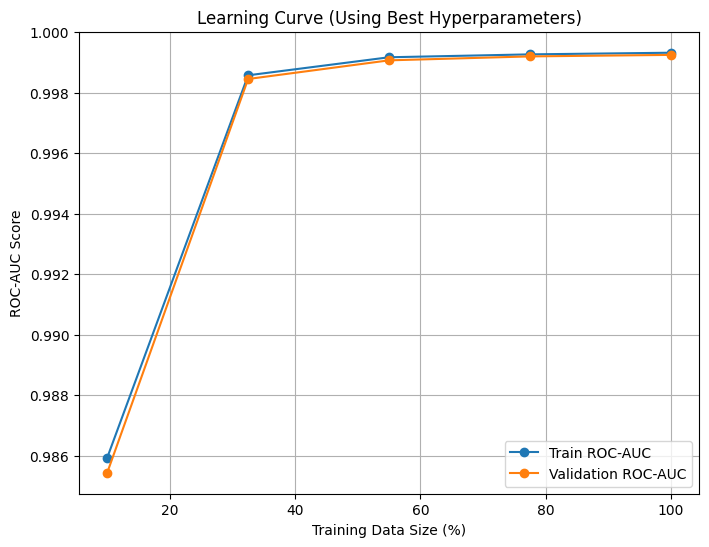

(array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
 [np.float64(0.9859308137268137),
  np.float64(0.9985789148575627),
  np.float64(0.9991752409559542),
  np.float64(0.9992709568146716),
  np.float64(0.9993256368268946)],
 [np.float64(0.9854344294832644),
  np.float64(0.9984565676298223),
  np.float64(0.9990736246219717),
  np.float64(0.9992037175477261),
  np.float64(0.999253699931574)])

In [18]:
# Learning Curve Analysis
plot_learning_curve_with_best_params(
    X_train, y_train, X_val, y_val, best_params=best_params
)

In [19]:
# Function to evaluate model and plot confusion matrix + ROC curve
def evaluate_and_plot(y_true, y_pred, y_pred_proba, model_name):
    """
    Evaluate model performance using precomputed predictions and probabilities.

    Args:
        y_true (array): True labels.
        y_pred (array): Predicted binary labels.
        y_pred_proba (array): Predicted probabilities.
        model_name (str): Name of the model for labeling outputs.

    Returns:
        roc_auc (float): ROC-AUC score of the model.
    """
    # Print Performance Metrics
    print(f"\n{model_name} Performance:")
    print(classification_report(y_true, y_pred))

    # Compute and Print Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Calculate Error Percentage
    total_samples = len(y_true)
    incorrect_predictions = np.sum(y_true != y_pred)
    error_percentage = (incorrect_predictions / total_samples) * 100

    print(f"Error Percentage: {error_percentage:.2f}%")

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Class 0", "Class 1"],
        yticklabels=["Class 0", "Class 1"],
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{model_name} ROC Curve", color="b")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} ROC Curve")
    plt.legend()
    plt.show()

    # ROC-AUC Score
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    print(f"{model_name} ROC-AUC: {roc_auc:.4f}")

    return roc_auc, error_percentage



XGBoost (Train) Performance:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95    159216
           1       0.99      0.91      0.95    159216

    accuracy                           0.95    318432
   macro avg       0.95      0.95      0.95    318432
weighted avg       0.95      0.95      0.95    318432

Confusion Matrix:
[[157797   1419]
 [ 14598 144618]]
Error Percentage: 5.03%


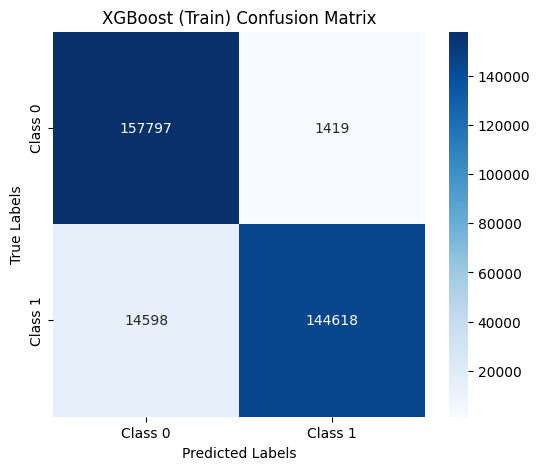

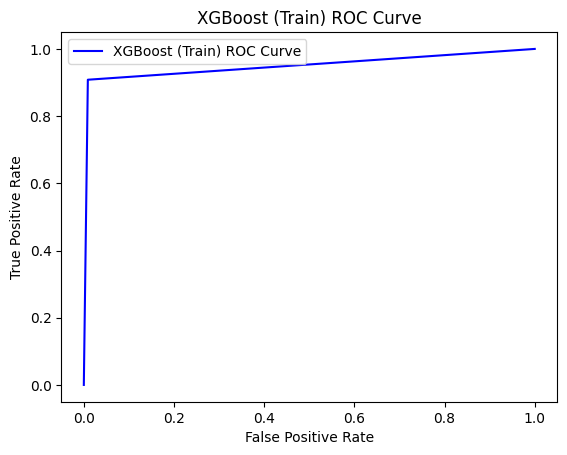

XGBoost (Train) ROC-AUC: 0.9497
Train Error Percentage: 5.03%



In [20]:
# Evaluate and plot for train data
train_roc_auc, train_error = evaluate_and_plot(
    y_train, y_train_pred, y_train_pred_proba, "XGBoost (Train)"
)
print(f"Train Error Percentage: {train_error:.2f}%\n")


XGBoost (Validation) Performance:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     39804
           1       0.99      0.91      0.95     39805

    accuracy                           0.95     79609
   macro avg       0.95      0.95      0.95     79609
weighted avg       0.95      0.95      0.95     79609

Confusion Matrix:
[[39411   393]
 [ 3524 36281]]
Error Percentage: 4.92%


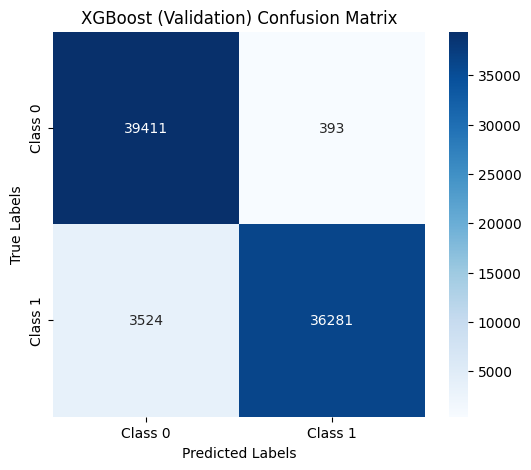

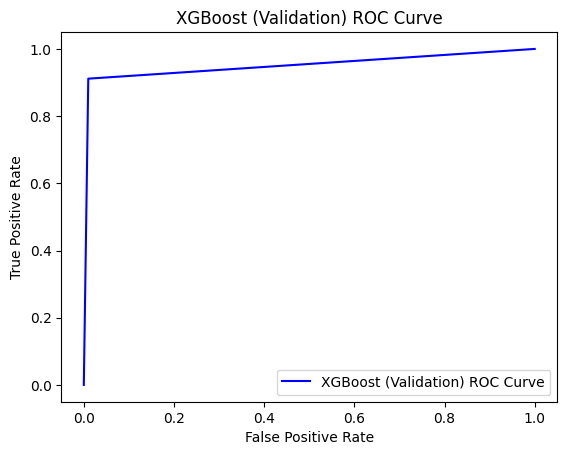

XGBoost (Validation) ROC-AUC: 0.9508
Validation Error Percentage: 4.92%



In [21]:
# Evaluate and plot for validation data
val_roc_auc, val_error = evaluate_and_plot(
    y_val, y_val_pred, y_val_pred_proba, "XGBoost (Validation)"
)
print(f"Validation Error Percentage: {val_error:.2f}%\n")



XGBoost (Test) Performance:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     85295
           1       0.99      0.91      0.95     85294

    accuracy                           0.95    170589
   macro avg       0.95      0.95      0.95    170589
weighted avg       0.95      0.95      0.95    170589

Confusion Matrix:
[[84477   818]
 [ 7675 77619]]
Error Percentage: 4.98%


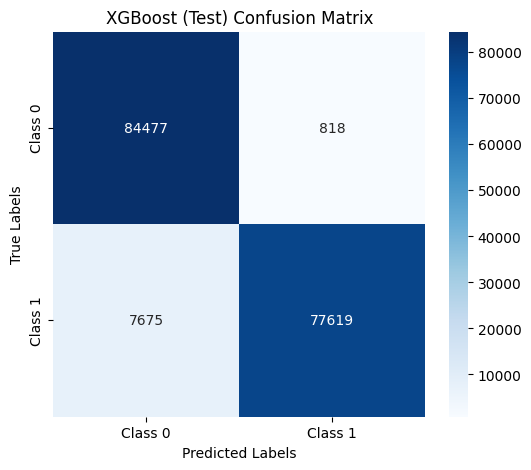

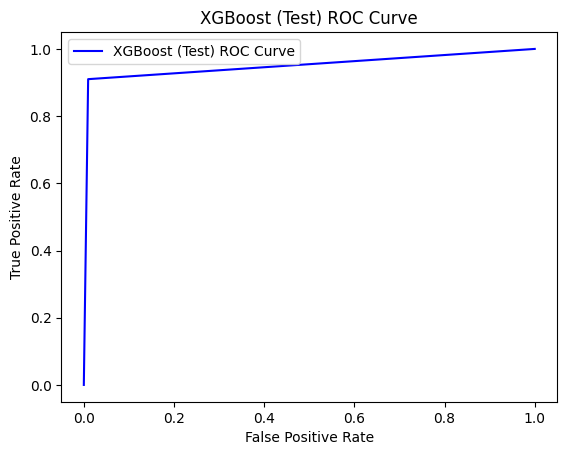

XGBoost (Test) ROC-AUC: 0.9502
Test Error Percentage: 4.98%



In [22]:
# Evaluate and plot for test data
test_roc_auc, test_error = evaluate_and_plot(
    y_test, y_test_pred, y_test_pred_proba, "XGBoost (Test)"
)
print(f"Test Error Percentage: {test_error:.2f}%\n")

/tmp/ipykernel_99985/3691652854.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val, plot_type="bar")


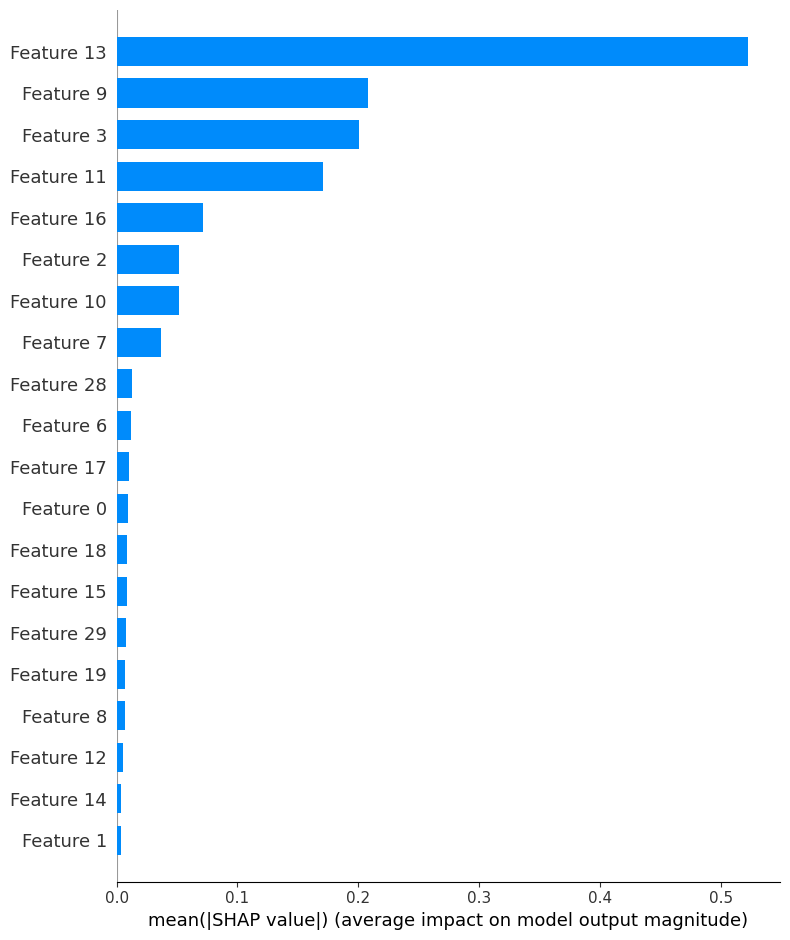

In [23]:
# Feature Importance with SHAP
explainer = shap.TreeExplainer(best_model.model.get_booster())
shap_values = explainer.shap_values(X_val)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_val, plot_type="bar")

In [24]:
# Save the model
joblib.dump(best_model, "../Models/fraud_detection_xgboost_model.pkl")
print("\nModel saved successfully!")


Model saved successfully!
